# Homelessness data CA 2020-2024

**Goal:** make sense of available data and make predictions.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Homelessness count by age group and region

Age groups are self-explanatory. Regions are organized in Continuums of Care (CoCs) that can either match exactly one county, or regroup multiple counties, or, in the case of LA county, be a subset of a county.

In [2]:
df = pd.read_csv(
    'data/cy_age.csv',
    na_values='*',
    dtype={
        'AGE_GROUP_PUBLIC': pd.CategoricalDtype(
            categories=[
                'Under 18',
                '18-24',
                '25-34',
                '35-44',
                '45-54',
                '55-64',
                '65+',
                'Unknown',
                'Invalid',
            ],
            ordered=True,
        ),
    },
)
# Columns: CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT

### Over time

Let's start by plotting the number of persons experiencing homelessness year over year.

<Axes: xlabel='CALENDAR_YEAR', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

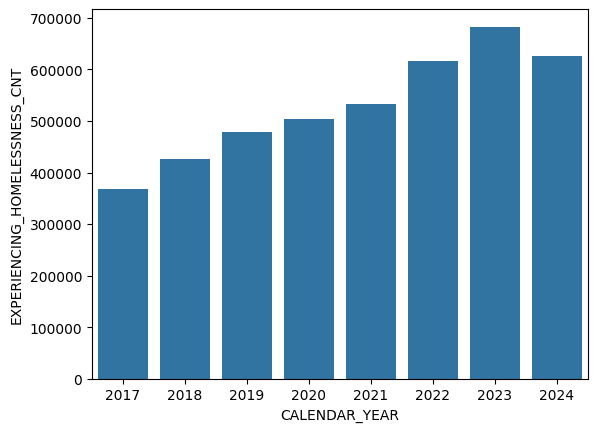

In [3]:
sns.barplot(
    df.groupby('CALENDAR_YEAR')[['EXPERIENCING_HOMELESSNESS_CNT']].sum(),
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    # stack_y="LOCATION",
)

### By age group

Now let's plot the same thing but by age group.

<Axes: xlabel='CALENDAR_YEAR', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

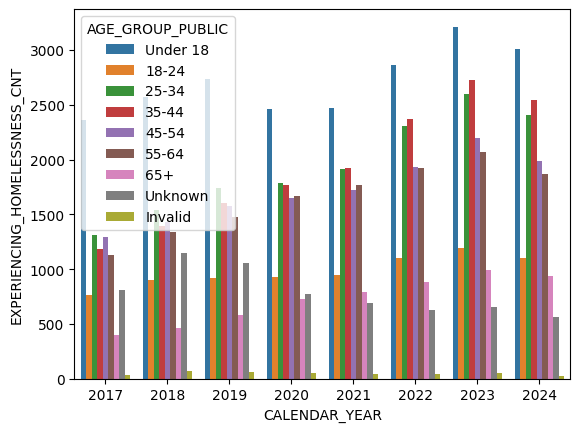

In [4]:
sns.barplot(
    df,
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    hue="AGE_GROUP_PUBLIC",
    errorbar=None,
)

It's easier to visulize if we group by age groups first.

<Axes: xlabel='AGE_GROUP_PUBLIC', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

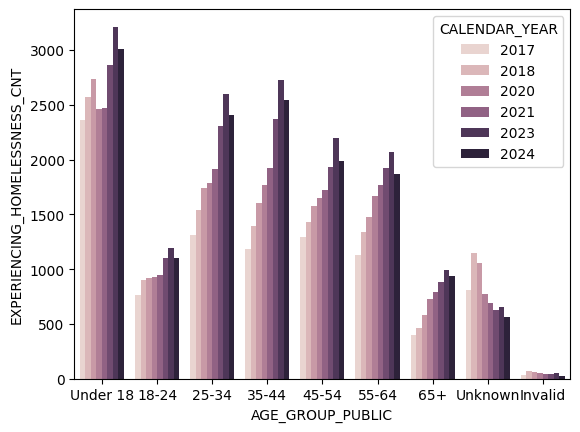

In [5]:
sns.barplot(
    df,
    x="AGE_GROUP_PUBLIC",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    hue="CALENDAR_YEAR",
    errorbar=None,
)

A stacked plot shows the progression year over year by age group while also showing the global trend.

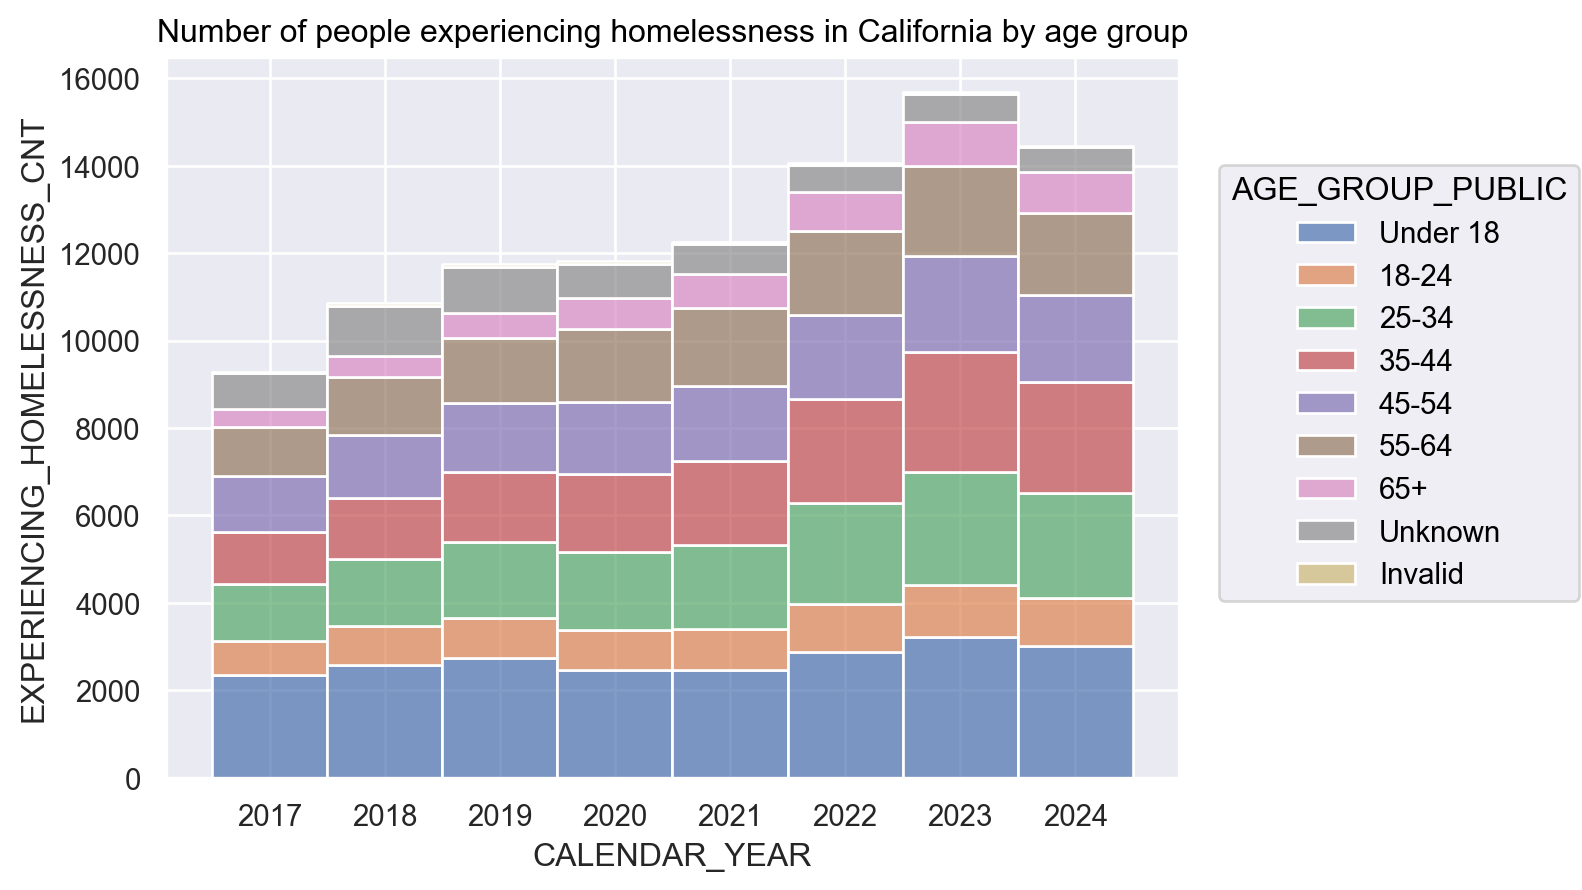

In [6]:
import seaborn.objects as so

so.Plot(
    df,
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    color="AGE_GROUP_PUBLIC",
).add(
    so.Bars(),
    so.Agg(),
    so.Stack(),
).scale(
    color=so.Nominal(
        order=[
            'Under 18',
            '18-24',
            '25-34',
            '35-44',
            '45-54',
            '55-64',
            '65+',
            'Unknown',
            'Invalid',
        ],
    )
).label(
    title="Number of people experiencing homelessness in California by age group"
)

## Load census data

We want to include total population data since it seems relevant to homeless population.

The census data I found only goes back to 2020 so let's ignore years 2017-2019 from now on.

In [7]:
census_df = pd.read_csv("data/census-ca-2020-2024.csv").drop('Base', axis=1)
census_df.head()

,County,2020,2021,2022,2023,2024
0,Alameda,1680614,1643856,1635693,1638142,1649060
1,Alpine,1179,1203,1169,1126,1099
2,Amador,40584,41245,41486,41798,42026
3,Butte,210222,206351,207384,207354,208334
4,Calaveras,45350,46262,46544,46580,46505


### Problem

Continuum of Care regions (CoCs) don't exactly map to counties.

Some CoCs span multiple counties (not a big problem) and some counties (Los Angeles) are split into multiple CoCs (big problem).

In [8]:
def extract_counties(region_str, all_county_list):
    """
    Extracts county names from a 'Region of Care' string.

    Args:
        region_str (str): The string describing the region of care.
        all_county_list (list): A list of all valid county names.

    Returns:
        list: A list of county names found in the region string.
              Returns all counties if region_str is 'California'.
    """
    if region_str == 'California':
        return all_county_list # Special case for the whole state

    clean_str = re.sub(r'\s+CoC.*$', '', region_str).strip()
    clean_str = re.sub(r'\s+Count(y|ies)$', '', clean_str).strip()
    counties = re.split(r',\s*|\s+and\s+', clean_str)

    extracted = [county.strip() for county in counties if county.strip()]

    if region_str in ['Long Beach CoC (Los Angeles County)',
                      'Pasadena CoC (Los Angeles County)',
                      'Glendale CoC (Los Angeles County)']:
        extracted = ['Los Angeles'] # Map these specific CoCs to Los Angeles County

    valid_counties = [c for c in extracted if c in all_county_list]
    if len(valid_counties) != len(extracted):
         print(f"Warning: Potential mismatch for region '{region_str}'. Extracted: {extracted}, Validated: {valid_counties}")

    if len(valid_counties) == 1 and valid_counties[0] in all_county_list:
         return valid_counties
    if len(valid_counties) > 0:
        return valid_counties
    print(f"Warning: Could not parse counties for region: '{region_str}' -> Extracted: {extracted}")
    return []

In [9]:
df['COUNTIES'] = df['LOCATION'].apply(lambda r: extract_counties(r, census_df.County.to_numpy()))
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES
0,2017,All,California,18-24,16275.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
1,2017,All,California,25-34,27785.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
2,2017,All,California,35-44,25006.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
3,2017,All,California,45-54,26669.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
4,2017,All,California,55-64,23239.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo]
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo]
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo]
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo]


We build a map from CoC to the counties composing it.

In [10]:
region_county_map = df[['LOCATION', 'COUNTIES']].drop_duplicates(subset=['LOCATION']).explode('COUNTIES')
region_county_map.rename(columns={'COUNTIES': 'County'}, inplace=True)
region_county_map

,LOCATION,County
0,California,Alameda
0,California,Alpine
0,California,Amador
0,California,Butte
0,California,Calaveras
...,...,...
314,San Bernardino County CoC,San Bernardino
322,Ventura County CoC,Ventura
331,Glendale CoC (Los Angeles County),Los Angeles
339,Imperial County CoC,Imperial


In [11]:
merged_df = pd.merge(
    region_county_map,
    census_df,
    on='County',
    how='left' # Use left join to keep all regions, even if county data is missing (though it shouldn't be here)
)
merged_df

,LOCATION,County,2020,2021,2022,2023,2024
0,California,Alameda,1680614,1643856,1635693,1638142,1649060
1,California,Alpine,1179,1203,1169,1126,1099
2,California,Amador,40584,41245,41486,41798,42026
3,California,Butte,210222,206351,207384,207354,208334
4,California,Calaveras,45350,46262,46544,46580,46505
...,...,...,...,...,...,...,...
114,San Bernardino County CoC,San Bernardino,2183526,2190877,2196029,2200805,2214281
115,Ventura County CoC,Ventura,843808,840009,835032,833071,835427
116,Glendale CoC (Los Angeles County),Los Angeles,9996634,9809239,9748447,9731837,9757179
117,Imperial County CoC,Imperial,179730,179206,179767,180585,181724


We can now add up the census population data from each county composing a CoC to find the total population of the Coc, by year.

In [12]:
population_by_region = merged_df.groupby('LOCATION')[['2020', '2021', '2022', '2023', '2024']].sum().reset_index()
population_by_region

,LOCATION,2020,2021,2022,2023,2024
0,Alameda County CoC,1680614,1643856,1635693,1638142,1649060
1,"Alpine, Inyo, Mono Counties CoC",33403,33386,32969,32881,32575
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",158464,159769,159076,159497,159472
3,Butte County CoC,210222,206351,207384,207354,208334
4,California,39521958,39142565,39142414,39198693,39431263
5,"Colusa, Glenn, Trinity Counties CoC",66852,66747,66100,65967,66020
6,Contra Costa County CoC,1166165,1163813,1160296,1162179,1172607
7,El Dorado County CoC,191250,193724,193071,192440,192823
8,"Fresno, Madera Counties CoC",1166047,1171898,1177521,1183301,1189557
9,Glendale CoC (Los Angeles County),9996634,9809239,9748447,9731837,9757179


Run some sanity checks.

In [13]:
for year in ['2020', '2021', '2022', '2023', '2024']:
    total_population = census_df[year].sum()
    california_population = population_by_region[population_by_region['LOCATION'] == 'California'][year].iloc[0]

    print(f"\n#", year)
    print(f"Total Population of all counties: {total_population}")
    print(f"Calculated Population for 'California' region: {california_population}")
    print(f"Match: {total_population == california_population}")


# 2020
Total Population of all counties: 39521958
Calculated Population for 'California' region: 39521958
Match: True

# 2021
Total Population of all counties: 39142565
Calculated Population for 'California' region: 39142565
Match: True

# 2022
Total Population of all counties: 39142414
Calculated Population for 'California' region: 39142414
Match: True

# 2023
Total Population of all counties: 39198693
Calculated Population for 'California' region: 39198693
Match: True

# 2024
Total Population of all counties: 39431263
Calculated Population for 'California' region: 39431263
Match: True


In [14]:
for year in ['2020', '2021', '2022', '2023', '2024']:
    mc_region = 'Monterey, San Benito Counties CoC'
    mc_counties = ['Monterey', 'San Benito']
    mc_pop_manual = census_df[census_df['County'].isin(mc_counties)][year].sum()
    mc_pop_calculated = population_by_region[population_by_region['LOCATION'] == mc_region][year].iloc[0]

    print(f"\n#", year)
    print(f"Manual Population for '{mc_region}': {mc_pop_manual}")
    print(f"Calculated Population for '{mc_region}': {mc_pop_calculated}")
    print(f"Match: {mc_pop_manual == mc_pop_calculated}")


# 2020
Manual Population for 'Monterey, San Benito Counties CoC': 505039
Calculated Population for 'Monterey, San Benito Counties CoC': 505039
Match: True

# 2021
Manual Population for 'Monterey, San Benito Counties CoC': 505948
Calculated Population for 'Monterey, San Benito Counties CoC': 505948
Match: True

# 2022
Manual Population for 'Monterey, San Benito Counties CoC': 504142
Calculated Population for 'Monterey, San Benito Counties CoC': 504142
Match: True

# 2023
Manual Population for 'Monterey, San Benito Counties CoC': 503978
Calculated Population for 'Monterey, San Benito Counties CoC': 503978
Match: True

# 2024
Manual Population for 'Monterey, San Benito Counties CoC': 505410
Calculated Population for 'Monterey, San Benito Counties CoC': 505410
Match: True


We can finally include the population in the main dataframe.

In [15]:
df['POPULATION'] = df[["CALENDAR_YEAR", "LOCATION"]].apply(
    lambda row: int(population_by_region[
        population_by_region["LOCATION"] == row["LOCATION"]
    ][str(row["CALENDAR_YEAR"])].iloc[0]) if row["CALENDAR_YEAR"] >= 2020 else pd.NA,
    axis=1,
)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
0,2017,All,California,18-24,16275.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
1,2017,All,California,25-34,27785.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
2,2017,All,California,35-44,25006.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
3,2017,All,California,45-54,26669.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
4,2017,All,California,55-64,23239.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
...,...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo],281843
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo],281843
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo],281843
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo],281843


Let's drop NAs (California) and LA county

In [16]:
df.dropna(inplace=True)
df.drop(df[df['COUNTIES'].apply(lambda counties: np.any(counties == ['Los Angeles']))].index, inplace=True)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
1095,2020,CA-500,Santa Clara County CoC,18-24,831.0,[Santa Clara],1924802
1096,2020,CA-500,Santa Clara County CoC,25-34,1729.0,[Santa Clara],1924802
1097,2020,CA-500,Santa Clara County CoC,35-44,1863.0,[Santa Clara],1924802
1098,2020,CA-500,Santa Clara County CoC,45-54,1758.0,[Santa Clara],1924802
1099,2020,CA-500,Santa Clara County CoC,55-64,1880.0,[Santa Clara],1924802
...,...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo],281843
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo],281843
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo],281843
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo],281843


In [17]:
df['POPULATION'] = pd.to_numeric(df['POPULATION'], errors='coerce')

# Random forest

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

The goal is to predict the homelessness count given the rest of the data.

In [19]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

Need to apply one-hot encoding to categories (location and age group).

In [20]:
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')

Start with a simple 80%/20% training/test split.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

Using basic settings. I'm sure we could fine tune this.

In [22]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [23]:
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

Extract just the relevant data and compute some error metrics.

In [24]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1764,2021,Kern County CoC,65+,912782,289.0,302.591762,13.591762,184.735995,4.7%
2547,2023,Riverside County CoC,65+,2503549,780.0,673.075448,106.924552,11432.859719,13.7%
2660,2024,Marin County CoC,18-24,256400,101.0,105.621721,4.621721,21.360301,4.6%
2557,2023,San Bernardino County CoC,Under 18,2200805,3047.0,3724.243245,677.243245,458658.412972,22.2%
1385,2020,Kern County CoC,18-24,906124,370.0,556.503451,186.503451,34783.537162,50.4%
...,...,...,...,...,...,...,...,...,...
1149,2020,"Monterey, San Benito Counties CoC",45-54,505039,282.0,334.739229,52.739229,2781.426301,18.7%
1482,2021,San Francisco CoC,35-44,815498,2343.0,2131.406214,211.593786,44771.930362,9.0%
1922,2022,Mendocino County CoC,35-44,90027,310.0,250.526958,59.473042,3537.042752,19.2%
2439,2023,El Dorado County CoC,Under 18,192440,195.0,126.820935,68.179065,4648.384846,35.0%


In [25]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##284 with no log transform

RMSE: 198.003


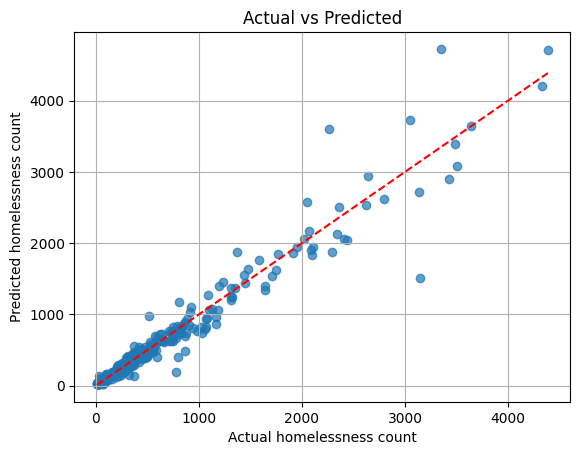

In [26]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

Results are decent, we're in the right ballpark. The relative error tends to be larger for smaller CoCs which makes sense.

# ANCOVA Model

In [27]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [28]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
model = smf.ols(formula, data=train_data).fit()

#print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 224.676


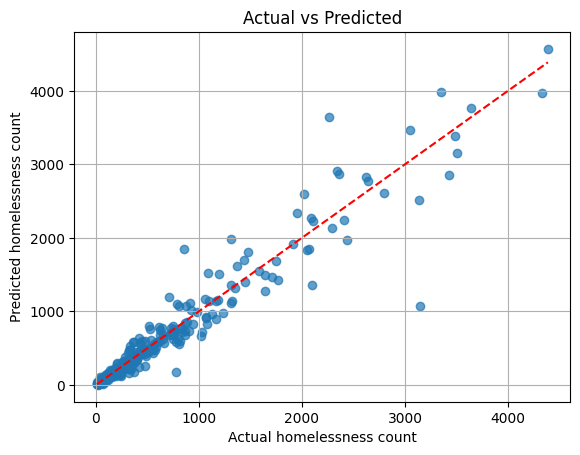

In [29]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

More investigation needed, but if we ignore the 1-2 point(s) that seems to have WAY underpredicted in the homelessness, this may be the better model and has the added benefit of interpretability. 

## Predict age group

Rather than a 80%/20% training/test split, we now want to predict data for an entire age group.

This is an extrapolation problem since the age group categories are unrelated (one-hot encoded) so we don't expect to do as well.

We try to predict the 65+ age group.

In [30]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

In [31]:
test_mask = df['AGE_GROUP_PUBLIC'] == '65+'
train_mask = ~test_mask
x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [32]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [33]:
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

Once again, let's compute the same error metrics.

In [34]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1100,2020,Santa Clara County CoC,65+,1924802,892.0,1864.512727,972.512727,9.457810e+05,109.0%
1108,2020,San Francisco CoC,65+,874826,788.0,1800.480312,1012.480312,1.025116e+06,128.5%
1117,2020,Alameda County CoC,65+,1680614,759.0,1411.349989,652.349989,4.255605e+05,85.9%
1126,2020,Sacramento County CoC,65+,1586727,572.0,1350.480468,778.480468,6.060318e+05,136.1%
1135,2020,Sonoma County CoC,65+,488501,242.0,482.393623,240.393623,5.778909e+04,99.3%
...,...,...,...,...,...,...,...,...,...
2913,2024,Riverside County CoC,65+,2529933,627.0,1732.284923,1105.284923,1.221655e+06,176.3%
2922,2024,San Bernardino County CoC,65+,2214281,402.0,1012.094778,610.094778,3.722156e+05,151.8%
2930,2024,Ventura County CoC,65+,835427,343.0,458.881617,115.881617,1.342855e+04,33.8%
2946,2024,Imperial County CoC,65+,181724,45.0,78.501804,33.501804,1.122371e+03,74.4%


In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##635 with no log: worse here?

RMSE: 692.431


The result are pretty bad, like 100% relative error, but this is expected for an extrapolation problem.

## Geography

What if we include geographical data, like the graph of neighboring CoCs for each CoC.

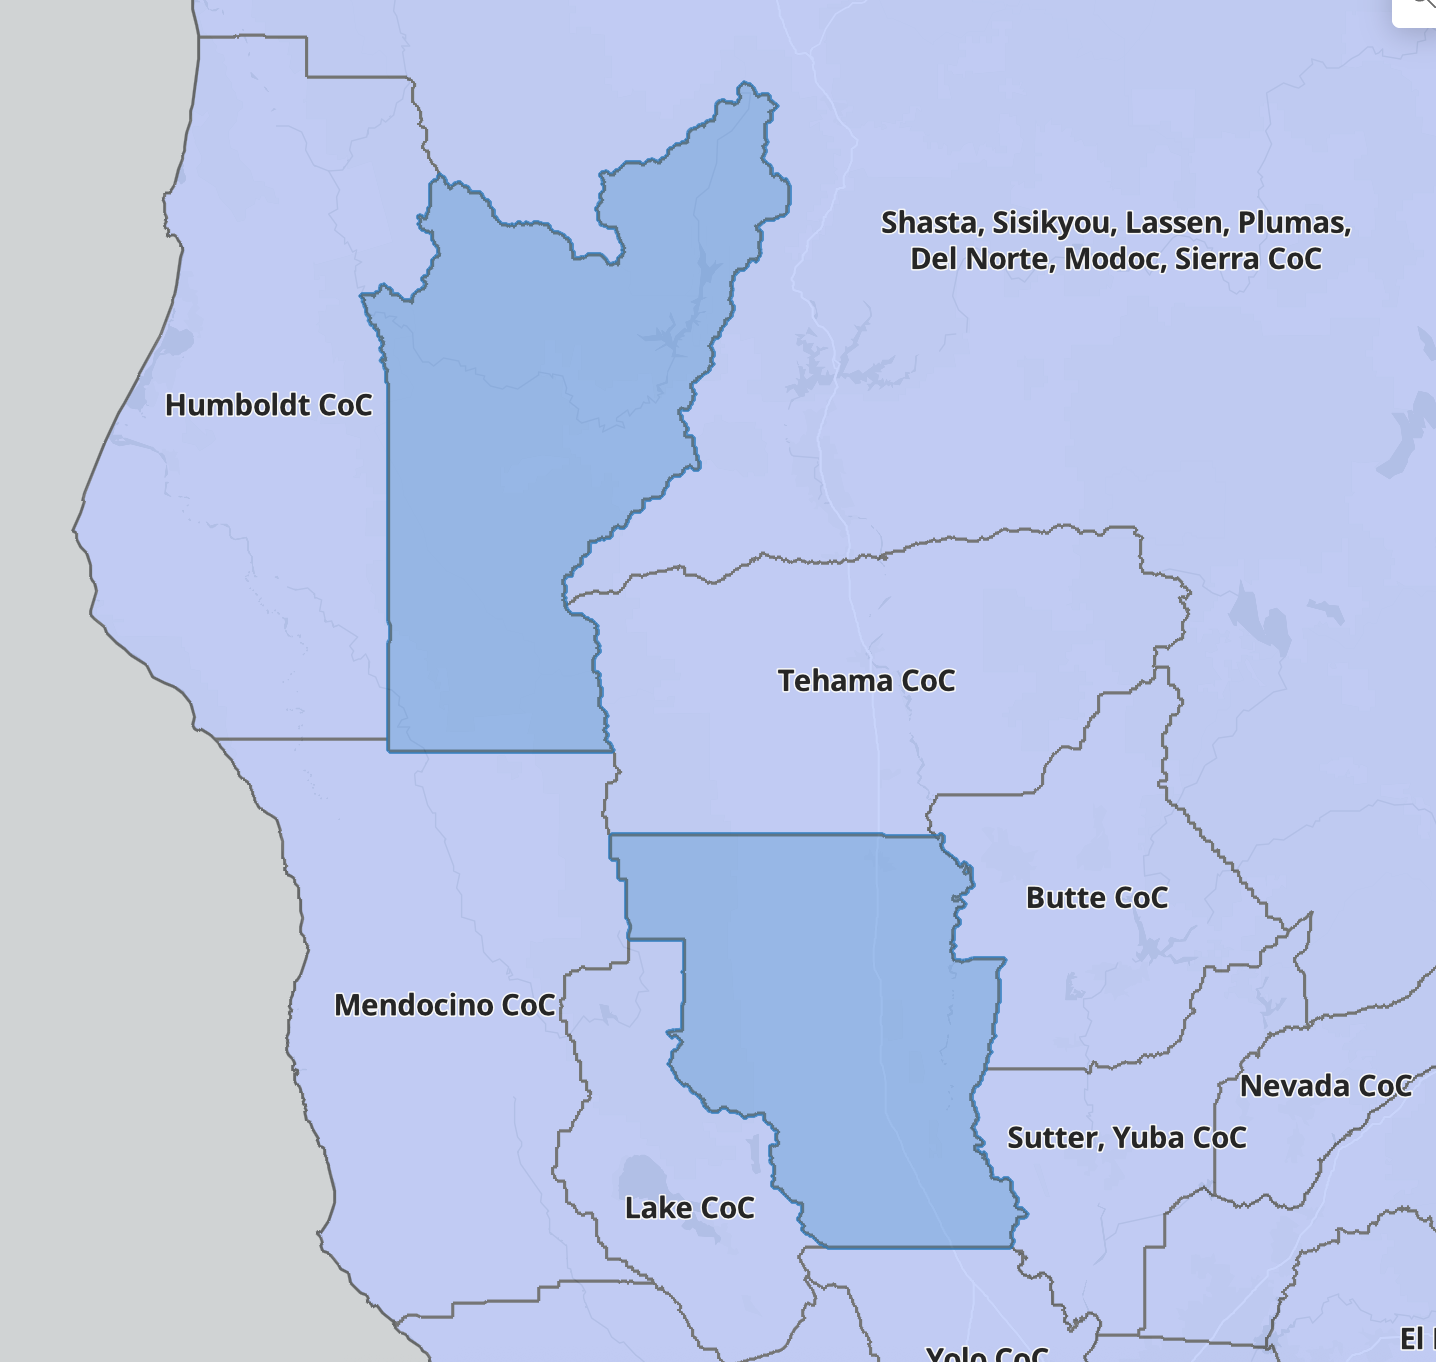
_Of course, geography is complicated. Here is a disjoint CoC._

The following is painstakingly manually extracted from this [interactive map][1].

[1]: https://experience.arcgis.com/experience/7227e954a08a4d2cb990949aa029275d/page/Find-Your-CoC/.

In [36]:
neighbors = {
    "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC": [
        "Humboldt County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Butte County CoC",
        "Yuba, Sutter Counties CoC",
        "Nevada County CoC",
    ],
    "Humboldt County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Mendocino County CoC",
    ],
    "Colusa, Glenn, Trinity Counties CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Humboldt County CoC",
        "Tehama County CoC",
        "Mendocino County CoC",
        "Lake County CoC",
        "Butte County CoC",
        "Yuba, Sutter Counties CoC",
        "Yolo County CoC",
    ],
    "Tehama County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Mendocino County CoC",
        "Butte County CoC",
    ],
    "Butte County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Yuba, Sutter Counties CoC",
    ],
    "Yuba, Sutter Counties CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Butte County CoC",
        "Nevada County CoC",
        "Placer County CoC",
    ],
    "Nevada County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Yuba, Sutter Counties CoC",
        "Placer County CoC",
    ],
    "Placer County CoC": [
        "Nevada County CoC",
        "Yuba, Sutter Counties CoC",
        "Sacramento County CoC",
        "El Dorado County CoC",
    ],
    "Mendocino County CoC": [
        "Humboldt County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Lake County CoC",
        "Sonoma County CoC",
    ],
    "Lake County CoC": [
        "Mendocino County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Sonoma County CoC",
        "Napa County CoC",
        "Yolo County CoC",
    ],
    "Sonoma County CoC": [
        "Mendocino County CoC",
        "Lake County CoC",
        "Napa County CoC",
        "Marin County CoC",
    ],
    "Napa County CoC": [
        "Sonoma County CoC",
        "Lake County CoC",
        "Yolo County CoC",
        "Solano County CoC",
    ],
    "Yolo County CoC": [
        "Lake County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Yuba, Sutter Counties CoC",
        "Sacramento County CoC",
        "Solano County CoC",
        "Napa County CoC",
    ],
    "Sacramento County CoC": [
        "Yolo County CoC",
        "Yuba, Sutter Counties CoC",
        "Placer County CoC",
        "El Dorado County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "San Joaquin County CoC",
        "Contra Costa County CoC",
        "Solano County CoC",
    ],
    "El Dorado County CoC": [
        "Placer County CoC",
        "Sacramento County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
    ],
    "Marin County CoC": [
        "Sonoma County CoC",
        "Contra Costa County CoC",
        "San Francisco CoC",
    ],
    "Solano County CoC": [
        "Napa County CoC",
        "Yolo County CoC",
        "Sacramento County CoC",
        "Contra Costa County CoC",
    ],
    "Contra Costa County CoC": [
        "Marin County CoC",
        "Solano County CoC",
        "Sacramento County CoC",
        "San Joaquin County CoC",
        "Alameda County CoC",
    ],
    "San Joaquin County CoC": [
        "Alameda County CoC",
        "Contra Costa County CoC",
        "Sacramento County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Stanislaus County CoC",
        "Santa Clara County CoC",
    ],
    "Amador, Calaveras, Mariposa, Tuolumne Counties CoC": [
        "Sacramento County CoC",
        "El Dorado County CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Fresno, Madera Counties CoC",
        "Merced County CoC",
        "Stanislaus County CoC",
        "San Joaquin County CoC",
    ],
    "Alpine, Inyo, Mono Counties CoC": [
        "El Dorado County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Fresno, Madera Counties CoC",
        "Kings, Tulare Counties CoC",
        "Kern County CoC",
        "San Bernardino County CoC",
    ],
    "San Francisco CoC": [
        "Marin County CoC",
        "Alameda County CoC",
        "San Mateo County CoC",
    ],
    "Alameda County CoC": [
        "San Francisco CoC",
        "San Mateo County CoC",
        "Contra Costa County CoC",
        "San Joaquin County CoC",
        "Santa Clara County CoC",
    ],
    "San Mateo County CoC": [
        "San Francisco CoC",
        "Alameda County CoC",
        "Santa Clara County CoC",
        "Santa Cruz County CoC",
    ],
    "Santa Cruz County CoC": [
        "San Mateo County CoC",
        "Santa Clara County CoC",
        "Monterey, San Benito Counties CoC",
    ],
    "Santa Clara County CoC": [
        "Santa Cruz County CoC",
        "San Mateo County CoC",
        "Alameda County CoC",
        "Stanislaus County CoC",
        "Merced County CoC",
        "Monterey, San Benito Counties CoC",
    ],
    "Stanislaus County CoC": [
        "Santa Clara County CoC",
        "San Joaquin County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Merced County CoC",
    ],
    "Merced County CoC": [
        "Stanislaus County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Santa Clara County CoC",
        "Monterey, San Benito Counties CoC",
        "Fresno, Madera Counties CoC",
    ],
    "Monterey, San Benito Counties CoC": [
        "Santa Cruz County CoC",
        "Santa Clara County CoC",
        "Merced County CoC",
        "Fresno, Madera Counties CoC",
        "Kings, Tulare Counties CoC",
        "San Luis Obispo County CoC",
    ],
    "Fresno, Madera Counties CoC": [
        "Monterey, San Benito Counties CoC",
        "Merced County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Kings, Tulare Counties CoC",
    ],
    "Kings, Tulare Counties CoC": [
        "Monterey, San Benito Counties CoC",
        "Fresno, Madera Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Kern County CoC",
    ],
    "San Luis Obispo County CoC": [
        "Monterey, San Benito Counties CoC",
        "Kern County CoC",
        "Santa Barbara County CoC",
    ],
    "Kern County CoC": [
        "San Luis Obispo County CoC",
        "Kings, Tulare Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "San Bernardino County CoC",
        # "Los Angeles CoC",
        "Ventura County CoC",
    ],
    "San Bernardino County CoC": [
        "Kern County CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Riverside County CoC",
        "Orange County CoC",
        # "Los Angeles CoC",
    ],
    "Santa Barbara County CoC": [
        "San Luis Obispo County CoC",
        "Ventura County CoC",
    ],
    "Ventura County CoC": [
        "Santa Barbara County CoC",
        "Kern County CoC",
        # "Los Angeles CoC",
    ],
    # "Los Angeles CoC": [
    #     "Glendale CoC",
    #     "Pasadena CoC",
    #     "Long Beach CoC",
    #     "Ventura County CoC",
    #     "Kern County CoC",
    #     "San Bernardino County CoC",
    #     "Orange County CoC",
    # ],
    # "Glendale CoC": [
    #     "Los Angeles CoC",
    #     "Pasadena CoC",
    # ],
    # "Pasadena CoC": [
    #     "Los Angeles CoC",
    #     "Glendale CoC",
    # ],
    # "Long Beach CoC": [
    #     "Los Angeles CoC",
    #     "Orange County CoC",
    # ],
    "Orange County CoC": [
        # "Los Angeles CoC",
        # "Long Beach CoC",
        "San Bernardino County CoC",
        "Riverside County CoC",
        "San Diego County CoC",
    ],
    "Riverside County CoC": [
        "San Bernardino County CoC",
        "Orange County CoC",
        "San Diego County CoC",
        "Imperial County CoC",
    ],
    "San Diego County CoC": [
        "Orange County CoC",
        "Riverside County CoC",
        "Imperial County CoC",
    ],
    "Imperial County CoC": [
        "Riverside County CoC",
        "San Diego County CoC",
    ],
}

Apply one-hot encoding.

In [37]:
def normalize(loc):
    return loc.replace(' ', '_').replace(',', '_').replace('__', '_')

df["NEIGHBORS"] = df.LOCATION.apply(lambda loc: neighbors[loc])
for loc, neigh in neighbors.items():
    df[f"NEAR_{normalize(loc)}"] = df.LOCATION.apply(lambda l: l in neigh)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION,NEIGHBORS,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_Modoc_Sierra_Counties_CoC,NEAR_Humboldt_County_CoC,...,NEAR_Kings_Tulare_Counties_CoC,NEAR_San_Luis_Obispo_County_CoC,NEAR_Kern_County_CoC,NEAR_San_Bernardino_County_CoC,NEAR_Santa_Barbara_County_CoC,NEAR_Ventura_County_CoC,NEAR_Orange_County_CoC,NEAR_Riverside_County_CoC,NEAR_San_Diego_County_CoC,NEAR_Imperial_County_CoC
1095,2020,CA-500,Santa Clara County CoC,18-24,831.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1096,2020,CA-500,Santa Clara County CoC,25-34,1729.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1097,2020,CA-500,Santa Clara County CoC,35-44,1863.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1098,2020,CA-500,Santa Clara County CoC,45-54,1758.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1099,2020,CA-500,Santa Clara County CoC,55-64,1880.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo],281843,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,False,False,True,False,True,False,False,False,False,False
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo],281843,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,False,False,True,False,True,False,False,False,False,False
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo],281843,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,False,False,True,False,True,False,False,False,False,False
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo],281843,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,False,False,True,False,True,False,False,False,False,False


Run the same 80%/20% training/test split with the additional data.

In [38]:
x = df[features + [f"NEAR_{normalize(loc)}" for loc in neighbors.keys()]]
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

In [39]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1764,2021,Kern County CoC,65+,912782,289.0,319.006054,30.006054,900.363264,10.4%
2547,2023,Riverside County CoC,65+,2503549,780.0,622.384796,157.615204,24842.552568,20.2%
2660,2024,Marin County CoC,18-24,256400,101.0,115.169573,14.169573,200.776810,14.0%
2557,2023,San Bernardino County CoC,Under 18,2200805,3047.0,3713.372401,666.372401,444052.177296,21.9%
1385,2020,Kern County CoC,18-24,906124,370.0,554.788611,184.788611,34146.830828,49.9%
...,...,...,...,...,...,...,...,...,...
1149,2020,"Monterey, San Benito Counties CoC",45-54,505039,282.0,329.639157,47.639157,2269.489278,16.9%
1482,2021,San Francisco CoC,35-44,815498,2343.0,2216.054440,126.945560,16115.175152,5.4%
1922,2022,Mendocino County CoC,35-44,90027,310.0,264.251492,45.748508,2092.926004,14.8%
2439,2023,El Dorado County CoC,Under 18,192440,195.0,132.474992,62.525008,3909.376585,32.1%


In [40]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##257 without log transform

RMSE: 211.522


RMSE was 284 so we get about 10% improvement by taking into account the geography (as a graph of connected CoCs).

### Mixed Effects Models with Spatial location

In [41]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features + [f"NEAR_{normalize(loc)}" for loc in neighbors.keys()]] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')
# for loc in neighbors.keys():
    # train_data[f"NEAR_{normalize(loc)}"] = train_data[f"NEAR_{normalize(loc)}"].astype('float64')
    # train_data[f"NEAR_{normalize(loc)}"] = train_data[f"NEAR_{normalize(loc)}"].astype('category')
    # train_data[f"NEAR_{normalize(loc)}"] -= 0.5
    # print(train_data[f"NEAR_{normalize(loc)}"])
    # break

train_data['NEAR_Humboldt_County_CoC'] = train_data['NEAR_Humboldt_County_CoC'].astype('category')
x_test['NEAR_Humboldt_County_CoC'] = x_test['NEAR_Humboldt_County_CoC'].astype('category')

In [42]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    'log_homeless ~ C(AGE_GROUP_PUBLIC) + POPULATION + CALENDAR_YEAR',
    data=train_data,
    groups=train_data['LOCATION']
).fit(method='lbfgs')

print(model.summary())

y_pred = model.predict(x_test)

y_pred = np.exp(y_pred)
y_test =np.exp(y_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        log_homeless
No. Observations:         1177           Method:                    REML        
No. Groups:               40             Scale:                     0.1755      
Min. group size:          25             Log-Likelihood:            -765.2395   
Max. group size:          37             Converged:                 Yes         
Mean group size:          29.4                                                  
--------------------------------------------------------------------------------
                                Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------------
Intercept                      -152.640   17.620  -8.663 0.000 -187.174 -118.106
C(AGE_GROUP_PUBLIC)[T.18-24]     -1.160    0.048 -24.325 0.000   -1.254   -1.067
C(AGE_GROUP_PUBLIC)[T.25-34]     -0.429    0.047  

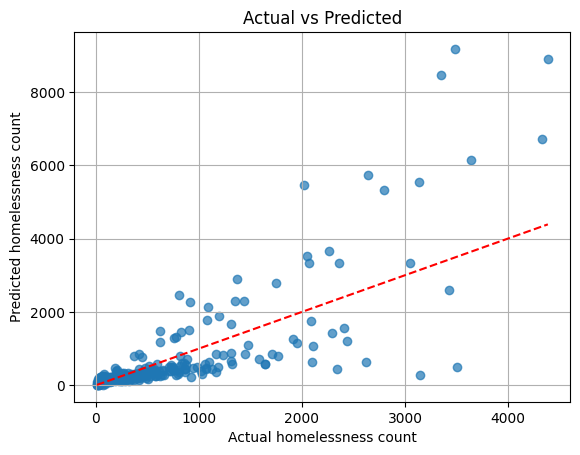

In [43]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Topological distance

In [44]:
import collections

def calculate_topological_distances(graph_data):
    """
    Calculates the topological distance (number of hops) between all pairs of nodes
    in an unweighted graph using Breadth-First Search (BFS).

    Args:
        graph_data (dict): A dictionary representing the adjacency list of the graph.
                           Keys are node names, and values are lists of their neighbors.

    Returns:
        pandas.DataFrame: A DataFrame where both index and columns are node names,
                          and values are the topological distances.
                          Returns float('inf') if nodes are unreachable.
    """
    # Create a set of all unique CoC names to ensure all nodes are included
    all_coc_names = set(graph_data.keys())
    for neighbors_list in graph_data.values():
        all_coc_names.update(neighbors_list)
    all_coc_names = sorted(list(all_coc_names))

    # Build a symmetric adjacency list to ensure bidirectional connections
    # This is crucial for accurate distance calculations in an undirected graph.
    symmetric_graph = {coc: set() for coc in all_coc_names}
    for node, neighbors_list in graph_data.items():
        for neighbor in neighbors_list:
            symmetric_graph[node].add(neighbor)
            symmetric_graph[neighbor].add(node) # Ensure symmetry

    # Initialize a dictionary to store all-pairs distances
    all_pairs_distances = {}

    # Perform BFS from each CoC to find distances to all other CoCs
    for start_node in all_coc_names:
        distances = {node: float('inf') for node in all_coc_names}
        distances[start_node] = 0
        queue = collections.deque([start_node])

        while queue:
            current_node = queue.popleft()

            # Iterate over neighbors, ensuring they exist in the symmetric_graph
            for neighbor in symmetric_graph.get(current_node, []):
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current_node] + 1
                    queue.append(neighbor)
        all_pairs_distances[start_node] = distances

    # Convert the results into a pandas DataFrame
    distance_df = pd.DataFrame(all_pairs_distances)
    # Reorder columns and index to be consistent
    distance_df = distance_df.reindex(index=all_coc_names, columns=all_coc_names)

    return distance_df

# Calculate the topological distances
topological_distances_df = calculate_topological_distances(neighbors)

In [45]:
def add_topological_distance_columns(df, location_column, topological_distances_df):
    """
    Adds new columns to a DataFrame, representing the topological distance from
    the CoC in the specified location_column to all other CoCs.

    Args:
        df (pandas.DataFrame): The input DataFrame with a CoC name column.
        location_column (str): The name of the column in df that contains CoC names.
        topological_distances_df (pandas.DataFrame): The DataFrame containing
                                                     all-pairs topological distances.

    Returns:
        pandas.DataFrame: The DataFrame with added distance columns.
    """
    # Get the list of all CoC names from the topological_distances_df columns
    all_coc_names = topological_distances_df.columns.tolist()

    # Create new columns for distances, initialized to NaN
    for coc_name in all_coc_names:
        df[f'DIST_{normalize(coc_name)}'] = float('nan')

    # Populate the new distance columns
    for index, row in df.iterrows():
        current_coc = row[location_column]
        if current_coc in topological_distances_df.index:
            # Get the row of distances for the current CoC
            distances_from_current_coc = topological_distances_df.loc[current_coc]
            for other_coc in all_coc_names:
                df.at[index, f'DIST_{normalize(other_coc)}'] = distances_from_current_coc.get(other_coc, float('inf'))
        else:
            print(f"Warning: CoC '{current_coc}' not found in topological distances. Skipping row {index}.")

    return df

In [46]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_topological_distance_columns(df[features].copy(), 'LOCATION', topological_distances_df) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [47]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += " + "
formula += " + ".join([f"DIST_{normalize(loc)}" for loc in neighbors.keys()])
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 224.676


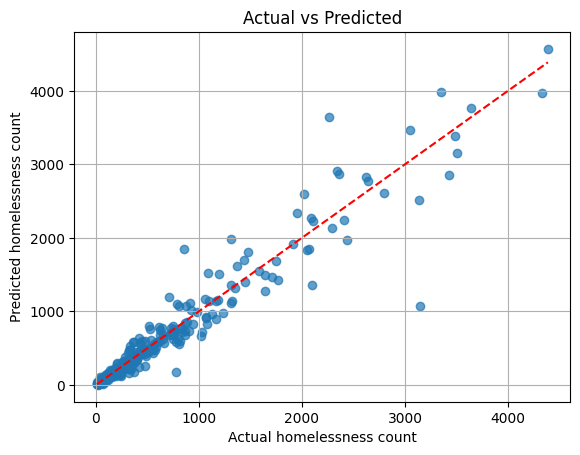

In [48]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Average neighbor population

In [49]:
def add_average_neighbor_population(df, location_column, population_column, graph_data):
    """
    Adds a new column to the DataFrame with the average population of neighboring CoCs.

    Args:
        df (pandas.DataFrame): The input DataFrame with CoC names and population.
        location_column (str): The name of the column in df that contains CoC names.
        population_column (str): The name of the column in df that contains population data.
        graph_data (dict): The adjacency list of the graph (e.g., `neighbors` dictionary).

    Returns:
        pandas.DataFrame: The DataFrame with the 'AVG_NEIGHBOR_POPULATION' column added.
    """
    # Create a mapping of CoC to Population for efficient lookup
    coc_population_map = df.set_index(location_column)[population_column].to_dict()

    # Build a symmetric adjacency list for accurate neighbor lookup
    all_coc_names = set(graph_data.keys())
    for neighbors_list in graph_data.values():
        all_coc_names.update(neighbors_list)
    symmetric_graph = {coc: set() for coc in all_coc_names}
    for node, neighbors_list in graph_data.items():
        for neighbor in neighbors_list:
            symmetric_graph[node].add(neighbor)
            symmetric_graph[neighbor].add(node) # Ensure symmetry

    # Initialize the new column
    df['AVG_NEIGHBOR_POPULATION'] = float('nan')

    for index, row in df.iterrows():
        current_coc = row[location_column]
        if current_coc in symmetric_graph:
            neighbors_of_current_coc = symmetric_graph[current_coc]
            neighbor_populations = []
            for neighbor_coc in neighbors_of_current_coc:
                if neighbor_coc in coc_population_map:
                    neighbor_populations.append(coc_population_map[neighbor_coc])
                else:
                    print(f"Warning: Population for neighbor '{neighbor_coc}' of '{current_coc}' not found in DataFrame. Skipping.")

            if neighbor_populations:
                df.at[index, 'AVG_NEIGHBOR_POPULATION'] = sum(neighbor_populations) / len(neighbor_populations)
            else:
                df.at[index, 'AVG_NEIGHBOR_POPULATION'] = 0 # Or np.nan, depending on desired behavior for CoCs with no populated neighbors
        else:
            print(f"Warning: CoC '{current_coc}' not found in graph data. Cannot calculate average neighbor population for row {index}.")

    return df

In [50]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_average_neighbor_population(df[features].copy(), 'LOCATION', 'POPULATION', neighbors) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [51]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += ' + AVG_NEIGHBOR_POPULATION'
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 224.676


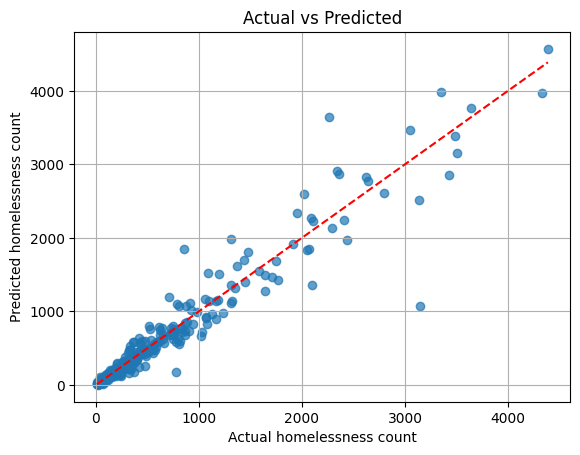

In [52]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Lattitude / longitude

In [53]:
def add_average_coc_lat_long(df, coc_names, county_lat_lng_path="data/us_county_latlng.csv"):
    """
    Computes the average latitude and longitude for each Continuum of Care (CoC) area
    based on the lat/long of its constituent counties.

    Args:
        df (pd.DataFrame): A dataframe
        coc_names (list): A list of CoC names (strings) for which to compute lat/long.
                          These names are expected to follow the convention:
                          "County1, County2, ... Counties CoC" or "County1 County CoC".
        county_lat_lng_url (str): URL to a CSV file containing county latitude and longitude data.
                                  Expected columns: 'fips_code', 'name', 'lat', 'lng'.

    Returns:
        pandas.DataFrame: A DataFrame with 'CoC_Name', 'Avg_Latitude', and 'Avg_Longitude' columns.
    """
    try:
        # Load county latitude/longitude data
        county_data = pd.read_csv(county_lat_lng_path, dtype={'fips_code': str})
        # Filter for California counties and convert county names to lowercase for robust matching
        ca_county_data = county_data[county_data['fips_code'].str.startswith('06')].copy()
        ca_county_data['county_name_lower'] = ca_county_data['name'].str.lower()
        county_lat_lng_map = ca_county_data.set_index('county_name_lower')[['lat', 'lng']].to_dict('index')
    except Exception as e:
        raise RuntimeError(f"Error loading or processing county lat/lng data from {county_lat_lng_path}: {e}")

    for coc_name in coc_names:
        # Extract county names from the CoC name
        # Remove " Counties CoC" or " County CoC" and then split by comma
        cleaned_name = re.sub(r'( Counties CoC| County CoC| CoC)$', '', coc_name)
        # Handle cases like "Alpine, Inyo, Mono Counties CoC"
        # and "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC"
        counties_in_coc = [c.strip().lower() for c in cleaned_name.split(',')]

        total_lat = 0
        total_lng = 0
        found_counties_count = 0
        missing_counties = []

        for county in counties_in_coc:
            # Handle specific naming discrepancies if known, e.g., "del norte" vs "del-norte"
            # For now, rely on direct lowercased match.
            if county in county_lat_lng_map:
                total_lat += county_lat_lng_map[county]['lat']
                total_lng += county_lat_lng_map[county]['lng']
                found_counties_count += 1
            else:
                missing_counties.append(county)

        if found_counties_count > 0:
            avg_lat = total_lat / found_counties_count
            avg_lng = total_lng / found_counties_count
        else:
            avg_lat = float('nan')
            avg_lng = float('nan')
            print(f"Warning: No valid county lat/long data found for CoC '{coc_name}'. Missing counties: {missing_counties}")

        df.loc[df['LOCATION'] == coc_name, 'LATTITUDE'] = avg_lat
        df.loc[df['LOCATION'] == coc_name, 'LONGITUDE'] = avg_lng

    return df

In [54]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_average_coc_lat_long(df[features].copy(), neighbors.keys()) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [55]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += ' + LATTITUDE + LONGITUDE'
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 224.676


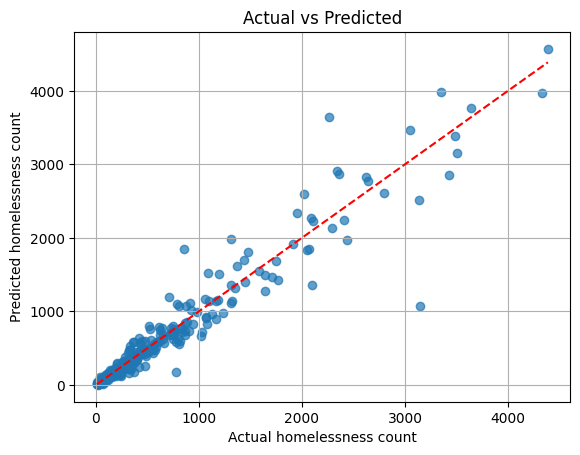

In [56]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

## Try predicting one missing county for last year

In [57]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')

In [58]:
test_mask = (df.LOCATION == 'Alameda County CoC') & (df.CALENDAR_YEAR == 2024)
train_mask = ~test_mask
x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [59]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [60]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
2619,2024,Alameda County CoC,18-24,1649060,7.003065,6.921550,0.081516,0.006645,1.2%
2620,2024,Alameda County CoC,25-34,1649060,7.741968,7.728373,0.013595,0.000185,0.2%
2621,2024,Alameda County CoC,35-44,1649060,7.729296,7.780382,0.051087,0.002610,0.7%
2622,2024,Alameda County CoC,45-54,1649060,7.559038,7.661106,0.102068,0.010418,1.4%
2623,2024,Alameda County CoC,55-64,1649060,7.574558,7.653863,0.079305,0.006289,1.0%
2624,2024,Alameda County CoC,65+,1649060,6.897705,6.804520,0.093185,0.008683,1.4%
2625,2024,Alameda County CoC,Under 18,1649060,7.763021,7.723674,0.039347,0.001548,0.5%
2626,2024,Alameda County CoC,Unknown,1649060,2.484907,3.314238,0.829331,0.687791,33.4%


In [61]:
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print("RMSE:", format(rmse, '.3f'))
##129 without log transform

RMSE: 115.732


Predictably, the results are good because the test data is much smaller than the training data, and we're interpolating. The _Unknown_ age group is completely off but this one feels like an exception.

## Compare actual with prediction when leaving one out

We'll do the same thing as above but systematically, by leaving one year/CoC/age group at a time and comparing the prediction to the actual data.

The goal is to identify the _surprise_ which might indicate CoCs doing something right (or wrong) for a certain year/age group, which we might be able to correlate with funding, policies, etc.

In [62]:
res = x.copy()

def pred(series):
    print(series.name)
    test_mask = df.index == series.name
    train_mask = ~test_mask
    x_train = x[train_mask]
    x_test = x[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    model.fit(x_train, y_train)
    return pd.Series([model.predict(x_test)[0], y_test.iloc[0]], index=['PRED', 'ACTUAL'])

res['LOCATION'] = df.LOCATION[res.index]
res['AGE_GROUP_PUBLIC'] = df.AGE_GROUP_PUBLIC[res.index]
res[['PRED', 'ACTUAL']] = res.apply(pred, axis=1)
res['ABS_ERROR'] = np.abs(res.PRED - res.ACTUAL)
res['SQ_ERROR'] = (res.PRED - res.ACTUAL)**2
res['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(res.ACTUAL, res.PRED)]
res

1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1110
1111
1112
1113
1114
1115
1116
1117
1119
1121
1122
1123
1124
1125
1126
1128
1129
1130
1131
1132
1133
1134
1135
1136
1138
1139
1140
1141
1142
1143
1145
1146
1147
1148
1149
1150
1151
1153
1154
1155
1156
1157
1158
1159
1160
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1177
1179
1180
1181
1182
1183
1184
1185
1187
1188
1189
1190
1191
1192
1194
1196
1197
1198
1199
1200
1201
1202
1204
1205
1206
1207
1208
1209
1211
1213
1214
1215
1216
1217
1218
1220
1221
1222
1223
1224
1225
1226
1227
1229
1230
1231
1232
1233
1234
1235
1236
1238
1239
1240
1241
1242
1243
1244
1245
1246
1248
1249
1250
1251
1252
1253
1254
1256
1257
1258
1259
1260
1261
1262
1264
1265
1266
1267
1268
1269
1271
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1295
1297
1298
1299
1300
1301
1302
1304
1305
1306
1307
1308
1309
1310
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322


,CALENDAR_YEAR,POPULATION,LOC__Alameda County CoC,"LOC__Alpine, Inyo, Mono Counties CoC","LOC__Amador, Calaveras, Mariposa, Tuolumne Counties CoC",LOC__Butte County CoC,"LOC__Colusa, Glenn, Trinity Counties CoC",LOC__Contra Costa County CoC,LOC__El Dorado County CoC,"LOC__Fresno, Madera Counties CoC",...,AGE__65+,AGE__Unknown,AGE__Invalid,LOCATION,AGE_GROUP_PUBLIC,PRED,ACTUAL,ABS_ERROR,SQ_ERROR,REL_ERROR
1095,2020,1924802,False,False,False,False,False,False,False,False,...,False,False,False,Santa Clara County CoC,18-24,6.722344,6.722630,0.000286,8.165062e-08,0.0%
1096,2020,1924802,False,False,False,False,False,False,False,False,...,False,False,False,Santa Clara County CoC,25-34,7.531773,7.455298,0.076475,5.848368e-03,1.0%
1097,2020,1924802,False,False,False,False,False,False,False,False,...,False,False,False,Santa Clara County CoC,35-44,7.507018,7.529943,0.022925,5.255686e-04,0.3%
1098,2020,1924802,False,False,False,False,False,False,False,False,...,False,False,False,Santa Clara County CoC,45-54,7.468046,7.471932,0.003886,1.510364e-05,0.1%
1099,2020,1924802,False,False,False,False,False,False,False,False,...,False,False,False,Santa Clara County CoC,55-64,7.456889,7.539027,0.082138,6.746706e-03,1.1%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953,2024,281843,False,False,False,False,False,False,False,False,...,False,False,False,San Luis Obispo County CoC,45-54,5.987631,6.079933,0.092302,8.519716e-03,1.5%
2954,2024,281843,False,False,False,False,False,False,False,False,...,False,False,False,San Luis Obispo County CoC,55-64,5.880363,5.894403,0.014040,1.971087e-04,0.2%
2955,2024,281843,False,False,False,False,False,False,False,False,...,True,False,False,San Luis Obispo County CoC,65+,5.252338,5.241747,0.010591,1.121745e-04,0.2%
2956,2024,281843,False,False,False,False,False,False,False,False,...,False,False,False,San Luis Obispo County CoC,Under 18,6.430509,6.697034,0.266525,7.103583e-02,4.0%


Show more compact results.

In [63]:
res['DIFF'] = (res.PRED - res.ACTUAL) / res.ACTUAL
res['DIFF%'] = [f"{((y_pred1 - y_actual1) / y_actual1) * 100:.1f}%" for y_pred1, y_actual1 in zip(res.PRED, res.ACTUAL)]
small = res[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'ACTUAL', 'DIFF', 'DIFF%']]
small[small.AGE_GROUP_PUBLIC.apply(lambda g: g not in ["Invalid", "Unknown"])].sort_values("DIFF")

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,ACTUAL,DIFF,DIFF%
1289,2020,"Colusa, Glenn, Trinity Counties CoC",25-34,4.663439,-0.181251,-18.1%
1245,2020,Napa County CoC,65+,4.691348,-0.164051,-16.4%
1667,2021,"Colusa, Glenn, Trinity Counties CoC",65+,3.433987,-0.157312,-15.7%
2075,2022,Tehama County CoC,Under 18,5.384495,-0.152704,-15.3%
1240,2020,Napa County CoC,18-24,4.718499,-0.145766,-14.6%
...,...,...,...,...,...,...
1714,2021,"Alpine, Inyo, Mono Counties CoC",65+,2.564949,0.222700,22.3%
1342,2020,Nevada County CoC,18-24,3.496508,0.228195,22.8%
1293,2020,"Colusa, Glenn, Trinity Counties CoC",65+,2.708050,0.230065,23.0%
2457,2023,Lake County CoC,18-24,3.135494,0.293603,29.4%
